<h1 align='center'>Алгоритмы анализа данных</h1>

<h1 align='center'>Домашнее задание № 8</h1>

<h2 align='left'>Снижение размерности данных</h2>

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import datasets

import numpy as np

# <p style="background-color:lightgreen;font-family:newtimeroman;color:#662e2e;font-size:130%;text-align:center;border-radius:30px 30px;">Задача №1</p>

Обучить любую модель классификации на датасете IRIS до применения самописного PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

__Решение:__

In [2]:
# Загрузим датасет IRIS из sklearn 

iris = datasets.load_iris()

X = iris.data
y = iris.target
X.shape, y.shape

((150, 4), (150,))

In [3]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [4]:
#iris

In [5]:
# Для начала отмасштабируем выборку

X = X.astype(float)

X = standard_scale(X)

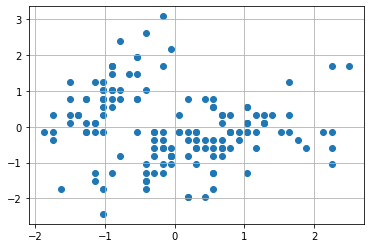

In [6]:
X = standard_scale(X)
plt.scatter(X[:, 0], X[:, 1])
plt.grid()

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [7]:
np.random.seed(42)

def get_bootstrap(X, y, N):
    n_samples = X.shape[0]  # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = X[sample_index]
        b_labels = y[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [8]:
# get_bootstrap(X, y, 4)

In [9]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))
    
    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    
    return subsample

In [10]:
# get_subsample(5)

In [11]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле        

In [12]:
# Реализуем класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        prediction = max(classes, key=classes.get)
        return prediction

In [13]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
               
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

In [14]:
# Расчет прироста

def gain(left_labels, right_labels, root_criterion, criterion):
    
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [15]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [16]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
       #  обозначим минимальное количество объектов в узле
#     min_leaf_samples = 5
    
    root_gini = gini(labels)
    
    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features)  # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
 #             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue

            current_gain = gain(true_labels, false_labels, root_gini, gini)
    
            #  выбираем порог, на котором получается максимальный прирост качества    
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
                
    return best_gain, best_t, best_index    

In [17]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Добавим функцию формирования случайного леса.

In [18]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [19]:
# Функция классификации отдельного объекта

def classify_object(obj, node):
    
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [20]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [21]:
# предсказание голосованием деревьев

def tree_vote(forest, data):
    
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
        # print(predictions)
        
        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))
        # print(predictions_per_object)
        
        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))
        
        return voted_predictions

In [22]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = train_test_split(X, y,
                                                                   test_size = 0.3,
                                                                   random_state = 42)

In [23]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [24]:
%%time
n_trees = 20
my_forest = random_forest(train_data, train_labels, n_trees)

CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 123 ms


In [25]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)
# И получим ответы для тестовой выборки
test_answer = tree_vote(my_forest, test_data)

In [26]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answer)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 20 деревьев на обучающей выборке: 94.286
Точность случайного леса из 20 деревьев на тестовой выборке: 91.111


Применем PCA

In [27]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.7746724797991, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021094, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.013531335697216, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.1072254642928576, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [28]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329985, 22.850761786701824, 3.6689218892828697, 0.5178709107154763]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Таким образом, первая главная компонента описывает почти 73% информации, а первые две в сумме - 95.8%. В то же время последняя компонента описывает всего 0.5% и может быть отброжена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

In [29]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [30]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

In [31]:
Z[:10]

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356]])

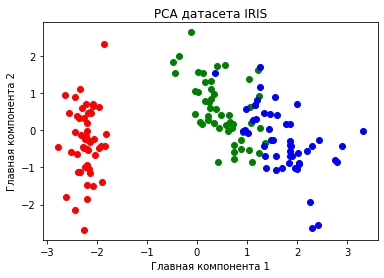

In [32]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [33]:
# # Разобьем выборку на обучающую и тестовую

# train_data, test_data, train_labels, test_labels = train_test_split(Z, y,
#                                                                    test_size = 0.3,
#                                                                    random_state = 42)

In [34]:
# Разобьем выборку на обучающую и тестовую, оставив y без изменения

train_data, test_data = train_test_split(Z,
                                        test_size = 0.3,
                                        random_state = 42)

In [35]:
%%time
# n_trees = 20
my_forest_pca = random_forest(train_data, train_labels, n_trees)

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 175 ms


In [36]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_pca, train_data)
# И получим ответы для тестовой выборки
test_answer = tree_vote(my_forest_pca, test_data)

In [37]:
# Точность на обучающей выборке
train_accuracy_pca = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_pca:.3f}')

# Точность на тестовой выборке
test_accuracy_pca = accuracy_metric(test_labels, test_answer)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_pca:.3f}')

Точность случайного леса из 20 деревьев на обучающей выборке: 93.333
Точность случайного леса из 20 деревьев на тестовой выборке: 84.444


Таким образом:

In [38]:
print(f'Точность случайного леса на обучающей выборке до PCA: {train_accuracy:.3f}')
print(f'Точность случайного леса на тестовой выборке до PCA: {test_accuracy:.3f}')
print(f'Точность случайного леса на обучающей выборке после PCA: {train_accuracy_pca:.3f}')
print(f'Точность случайного леса на тестовой выборке после PCA: {test_accuracy_pca:.3f}')
print(f'Точность модели снизилась на обучающей выборке на {(train_accuracy - train_accuracy_pca) * 100 / train_accuracy:.3f} %')
print(f'Точность модели снизилась на тестовой выборке на {(test_accuracy - test_accuracy_pca) * 100 / test_accuracy:.3f} %')

Точность случайного леса на обучающей выборке до PCA: 94.286
Точность случайного леса на тестовой выборке до PCA: 91.111
Точность случайного леса на обучающей выборке после PCA: 93.333
Точность случайного леса на тестовой выборке после PCA: 84.444
Точность модели снизилась на обучающей выборке на 1.010 %
Точность модели снизилась на тестовой выборке на 7.317 %


# <p style="background-color:lightgreen;font-family:newtimeroman;color:#662e2e;font-size:130%;text-align:center;border-radius:30px 30px;">Задача №2</p>

*Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)

In [39]:
# Загрузим датасет IRIS из sklearn 

iris = datasets.load_iris()

X = iris.data
y = iris.target
X.shape, y.shape

((150, 4), (150,))

In [40]:
# Для начала отмасштабируем выборку

X = X.astype(float)

X_scaled = standard_scale(X)

Сингулярное разложение $X^TX$

In [41]:
U, D, V = np.linalg.svd(X_scaled)

In [42]:
U.shape, D.shape, V.shape

((150, 150), (4,), (4, 4))

Оценим долю дисперсии, которая описывается найденными компонентами.

In [43]:
eig_sum = sum(D)
var_exp = [(i / eig_sum) * 100 for i in D]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[53.52971788236241, 29.95681278402008, 12.00368241720948, 4.509786916408033]
Кумулятивная доля дисперсии по компонентам 
[ 53.52971788  83.48653067  95.49021308 100.        ]


Сформируем из столбцов матрицы $V$, соответствующих $d$ наибольшим сингулярным числам, матрицу весов $W$

In [44]:
W = V[:, :3]
W

array([[ 0.52106591, -0.26934744,  0.5804131 ],
       [-0.37741762, -0.92329566, -0.02449161],
       [ 0.71956635, -0.24438178, -0.14212637],
       [ 0.26128628, -0.12350962, -0.80144925]])

Новая матрица "объекты-признаки"

In [45]:
Z = X @ W
Z

array([[ 2.39612466, -4.97204318,  2.51511939],
       [ 2.48062028, -4.45652586,  2.41128258],
       [ 2.22896694, -4.56287733,  2.30451427],
       [ 2.35851538, -4.49248937,  2.22049685],
       [ 2.30627631, -5.037438  ,  2.45462892],
       [ 2.66960455, -5.52018213,  2.47651892],
       [ 2.19946209, -4.75739086,  2.14721708],
       [ 2.45371647, -4.87721705,  2.4453146 ],
       [ 2.25782909, -4.22952257,  2.12352519],
       [ 2.48870653, -4.56094264,  2.4747657 ],
       [ 2.54891755, -5.26194472,  2.67013236],
       [ 2.42145992, -4.84778574,  2.31501935],
       [ 2.40238507, -4.41724016,  2.43338619],
       [ 1.9259822 , -4.2092519 ,  2.18581755],
       [ 2.42824872, -5.57335786,  2.93758803],
       [ 2.49330225, -6.01375784,  2.66682231],
       [ 2.38177801, -5.42242942,  2.53336946],
       [ 2.42225329, -4.98439414,  2.43497447],
       [ 2.83753746, -5.49630584,  2.73323693],
       [ 2.38098464, -5.28582102,  2.41341435],
       [ 2.8060561 , -5.03383238,  2.649